

# GLM Analysis (Simulated)

In this example we simulate a block design
functional near-infrared spectroscopy (fNIRS)
experiment and analyse
the simulated signal. We investigate the effect additive noise and
measurement length has on response amplitude estimates.


In [22]:
# sphinx_gallery_thumbnail_number = 3

# Authors: Robert Luke <mail@robertluke.net>
#
# License: BSD (3-clause)

import matplotlib.pylab as plt
import mne
import numpy as np
from nilearn.plotting import plot_design_matrix

import mne_nirs
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

np.random.seed(1)

## Simulate noise free NIRS data

First we simulate some noise free data. We simulate 5 minutes of data with a
block design. The inter stimulus interval of the stimuli is uniformly
selected between 15 and 45 seconds.
The amplitude of the simulated signal is 4 uMol and the sample rate is 3 Hz.
The simulated signal is plotted below.



In [39]:
sfreq = 3.0
amp = 4.0

raw = mne_nirs.simulation.simulate_nirs_raw(
    sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=15.0, isi_max=45.0
)
raw.plot(duration=300, show_scrollbars=False)

In [40]:
all_events, events_id = mne.events_from_annotations(raw)
all_events
events_id
print(raw)

Used Annotations descriptions: [np.str_('A')]
<RawArray | 1 x 900 (300.0 s), ~13 KiB, data loaded>


## Create design matrix

Next we create a design matrix based on the annotation times in the simulated
data. We use the nilearn plotting function to visualise the design matrix.
For more details on this procedure see `tut-fnirs-hrf`.



C:\Users\bede\AppData\Local\Temp\ipykernel_2232\2334072114.py:5: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  fig = plot_design_matrix(design_matrix, ax=ax1)


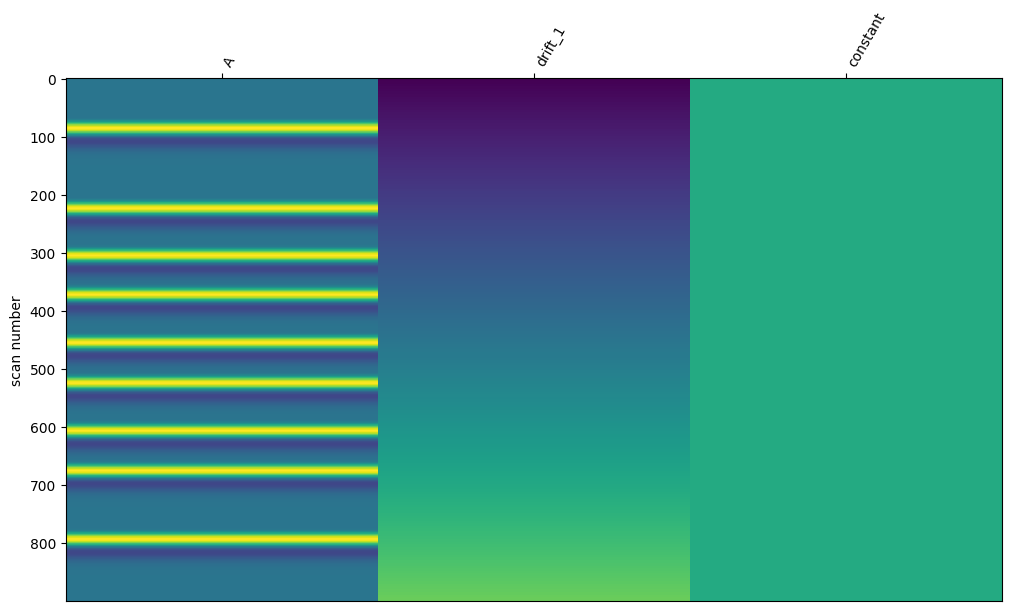

In [41]:
design_matrix = make_first_level_design_matrix(
    raw, stim_dur=5.0, drift_order=1, drift_model="polynomial"
)
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, ax=ax1)

Plot the modeled regressors

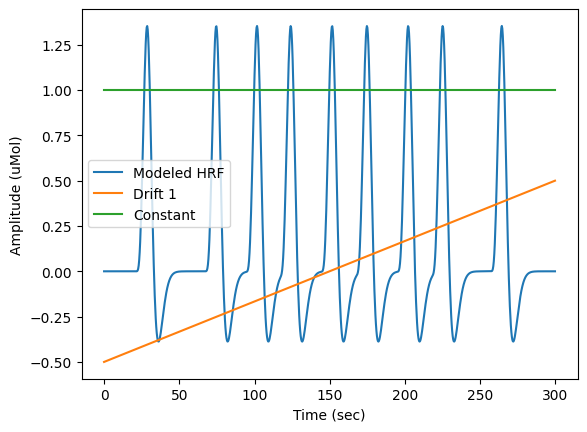

In [42]:
task_model_design_matrix = np.array(design_matrix["A"])
drift_model_design_matrix = np.array(design_matrix["drift_1"])
constant_design_matrix = np.array(design_matrix["constant"])
#full_model = task_model_design_matrix + drift_model_design_matrix + constant_design_matrix # without Beta weights
time = np.array(design_matrix.index)

plt.plot(time, task_model_design_matrix, label="Modeled HRF")
plt.plot(time, drift_model_design_matrix, label="Drift 1")
plt.plot(time, constant_design_matrix, label="Constant")

#plt.plot(time, full_model, label="GLM")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (uMol)")
plt.legend()

## Estimate response on clean data

Here we run the GLM analysis on the clean data.
The design matrix had three columns, so we get an estimate for our simulated
event, the first order drift, and the constant.
We see that the estimate of the first component is 4e-6 (4 uM),
which was the amplitude we used in the simulation.
We also see that the mean square error of the model fit is close to zero.



In [47]:
glm_est = run_glm(raw, design_matrix) # by default, noise="ar1"


def print_results(glm_est, truth):
    """Print the results of GLM estimate."""
    print(
        "Estimate:",
        glm_est.theta()[0][0],
        "  MSE:",
        glm_est.MSE()[0],
        "  Error (uM):",
        1e6 * (glm_est.theta()[0][0] - truth * 1e-6),
    )


print_results(glm_est, amp)
print(glm_est.model()[0].rho)

Estimate: [4.e-06]   MSE: 7.50812992725889e-43   Error (uM): [1.69406589e-15]
[0.]


## Simulate noisy NIRS data (white)

Real data has noise. Here we add white noise, this noise is not realistic
but serves as a reference point for evaluating the estimation process.
We run the GLM analysis exactly as in the previous section
and plot the noisy data and the GLM fitted model.
We print the response estimate and see that is close, but not exactly correct,
we observe the mean square error is similar to the added noise.
Note that the clean data plot is so similar to the GLM estimate that it is hard to
see unless zoomed in.



Estimate: [4.69105976e-06]   MSE: 3.188912660454376e-11   Error (uM): [0.69105976]
[-0.]


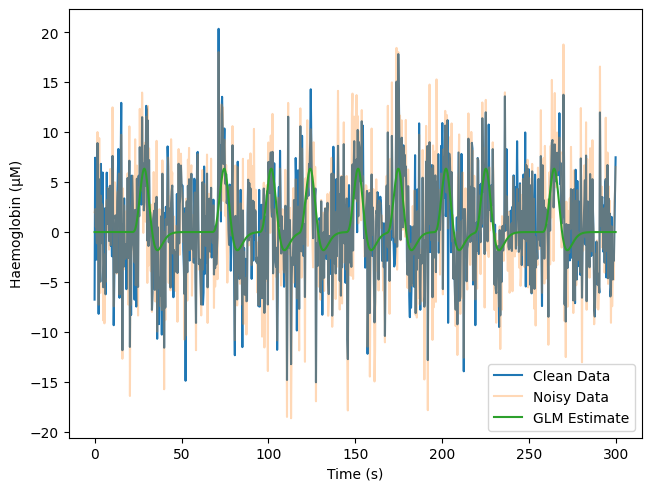

In [50]:
# First take a copy of noise free data for comparison
raw_noise_free = raw.copy()

raw._data += np.random.normal(0, np.sqrt(1e-11), raw._data.shape)
glm_est = run_glm(raw, design_matrix)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(raw.times, raw_noise_free.get_data().T * 1e6)
ax.plot(raw.times, raw.get_data().T * 1e6, alpha=0.3)
ax.plot(raw.times, glm_est.theta()[0][0] * design_matrix["A"].values * 1e6)
ax.set(xlabel="Time (s)", ylabel="Haemoglobin (μM)")
ax.legend(["Clean Data", "Noisy Data", "GLM Estimate"])

print_results(glm_est, amp)
print(glm_est.model()[0].rho*-1)

## Simulate noisy NIRS data (colored)

Here we add colored noise which better matches what is seen with real data.
Again, the same GLM procedure is run.
The estimate is reported below, and even though the signal was difficult to
observe in the raw data, the GLM analysis has extracted an accurate estimate.
However, the error is greater for the colored than white noise.



Adding noise to 1/1 channels (1 channels in cov)
Estimate: [3.9724444e-06]   MSE: 4.1027972228493413e-10   Error (uM): [-0.0275556]


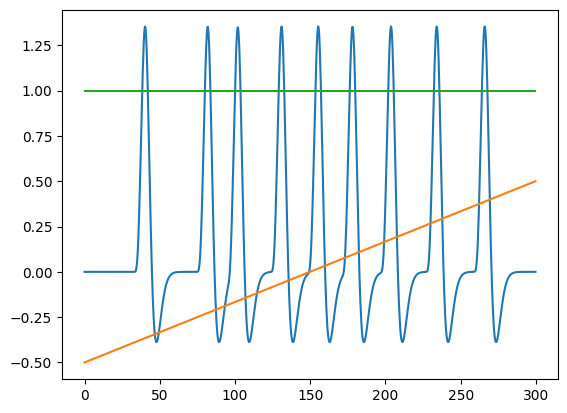

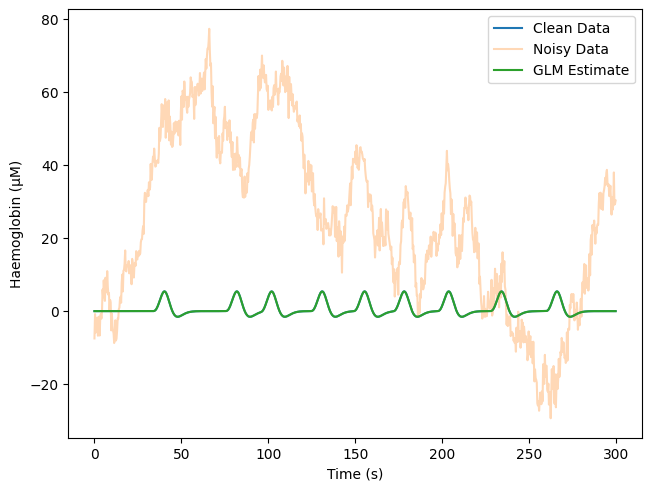

In [28]:
raw = raw_noise_free.copy()
cov = mne.Covariance(
    np.ones(1) * 1e-11, raw.ch_names, raw.info["bads"], raw.info["projs"], nfree=0
)
raw = mne.simulation.add_noise(
    raw,
    cov,
    iir_filter=[1.0, -0.58853134, -0.29575669, -0.52246482, 0.38735476, 0.02428681],
)
design_matrix = make_first_level_design_matrix(
    raw, stim_dur=5.0, drift_order=1, drift_model="polynomial"
)

task_model_design_matrix = np.array(design_matrix["A"])
drift_model_design_matrix = np.array(design_matrix["drift_1"])
constant_design_matrix = np.array(design_matrix["constant"])
#full_model = task_model_design_matrix + drift_model_design_matrix + constant_design_matrix # without Beta weights
time = np.array(design_matrix.index)

plt.plot(time, task_model_design_matrix, label="Modeled HRF")
plt.plot(time, drift_model_design_matrix, label="Drift 1")
plt.plot(time, constant_design_matrix, label="Constant")

glm_est = run_glm(raw, design_matrix)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(raw.times, raw_noise_free.get_data().T * 1e6)
ax.plot(raw.times, raw.get_data().T * 1e6, alpha=0.3)
ax.plot(raw.times, glm_est.theta()[0][0] * design_matrix["A"].values * 1e6)
ax.set(xlabel="Time (s)", ylabel="Haemoglobin (μM)")
ax.legend(["Clean Data", "Noisy Data", "GLM Estimate"])

print_results(glm_est, amp)

## How does increasing the measurement length affect estimation accuracy?

The easiest way to reduce error in your response estimate is to collect more
data. Here we simulated increasing the recording time to 30 minutes.
We run the same analysis and observe that the error is reduced from
approximately 0.6 uM for 5 minutes of data to 0.25 uM for 30 minutes of data.



Adding noise to 1/1 channels (1 channels in cov)
Estimate: [7.64782816e-06]   MSE: 6.910473055378267e-10   Error (uM): [3.64782816]


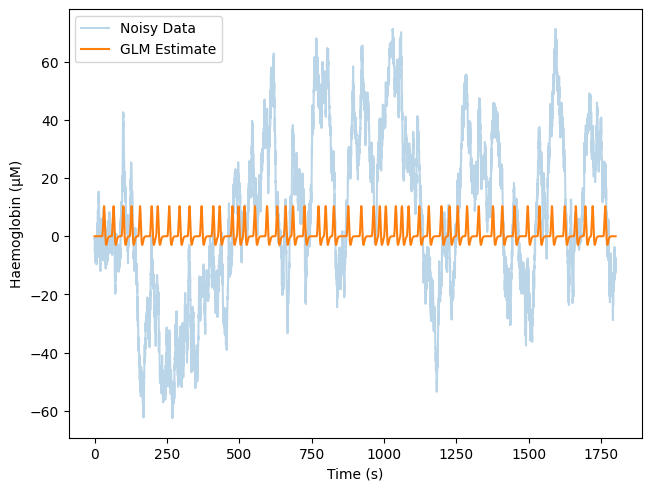

In [30]:
raw = mne_nirs.simulation.simulate_nirs_raw(
    sfreq=sfreq, sig_dur=60 * 30, amplitude=amp, isi_min=15.0, isi_max=45.0
)
cov = mne.Covariance(
    np.ones(1) * 1e-11, raw.ch_names, raw.info["bads"], raw.info["projs"], nfree=0
)
raw = mne.simulation.add_noise(
    raw,
    cov,
    iir_filter=[1.0, -0.58853134, -0.29575669, -0.52246482, 0.38735476, 0.02428681],
)

design_matrix = make_first_level_design_matrix(
    raw, stim_dur=5.0, drift_order=1, drift_model="polynomial"
)
glm_est = run_glm(raw, design_matrix)

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(raw.times, raw.get_data().T * 1e6, alpha=0.3)
ax.plot(raw.times, glm_est.theta()[0][0] * design_matrix["A"].values * 1e6)
ax.set(xlabel="Time (s)", ylabel="Haemoglobin (μM)")
ax.legend(["Noisy Data", "GLM Estimate"])

print_results(glm_est, amp)

## Using autoregressive models in the GLM to account for noise structure

An auto regressive noise model can be used account for temporal structure
in the noise. To account for the noise properties in the example above,
a fifth order auto regressive model is used below. Given this
is a simulation, we can verify if the correct estimate of the noise
properties was extracted from the data and if this
improved the response estimate.



c:\Users\bede\AppData\Local\anaconda3\envs\mne\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\bede\AppData\Local\anaconda3\envs\mne\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\bede\AppData\Local\anaconda3\envs\mne\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bede\AppData\Local\anaconda3\envs\mne\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\bede\AppData\Loca

Text(0.5, 0, 'Coefficient')

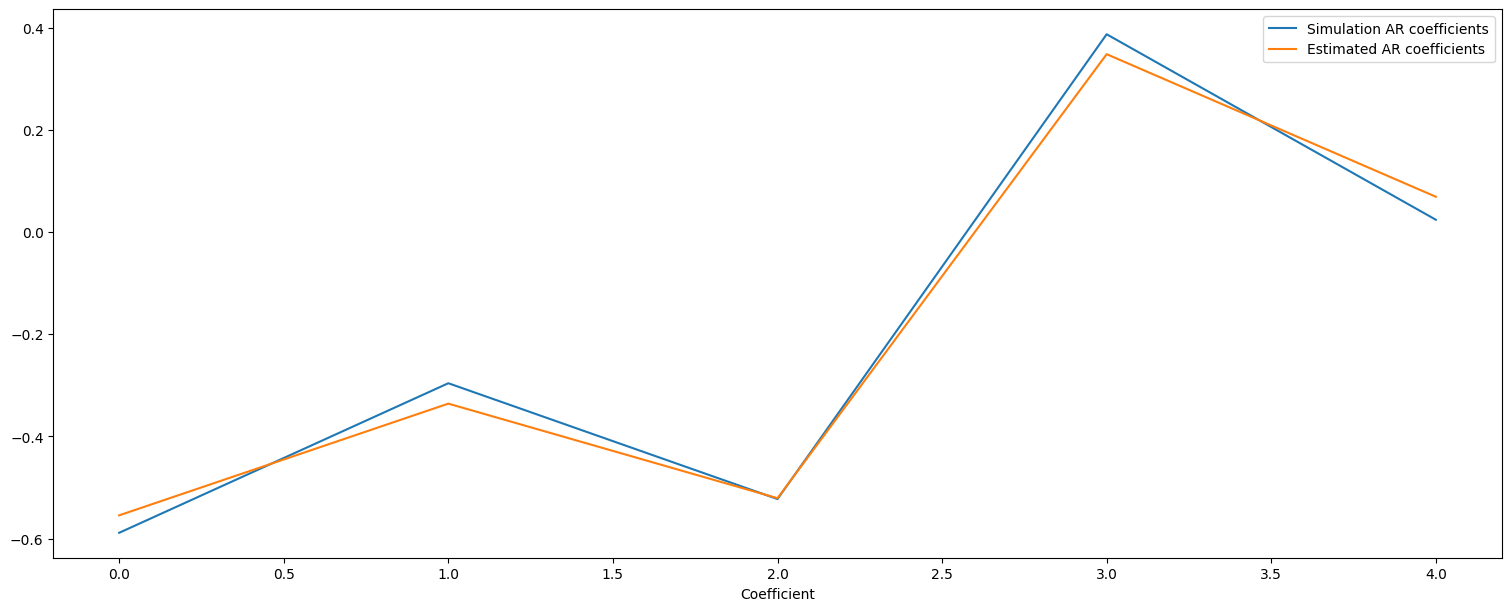

In [32]:
glm_est = run_glm(raw, design_matrix, noise_model="ar5")

fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
# actual values from model above
ax.plot([-0.58853134, -0.29575669, -0.52246482, 0.38735476, 0.02428681])
ax.plot(glm_est.model()[0].rho * -1.0)  # estimates
ax.legend(["Simulation AR coefficients", "Estimated AR coefficients"])
ax.set_xlabel("Coefficient")

We can see that the estimates from the GLM AR model are quite accurate,
but how does this affect the accuracy of the response estimate?



In [35]:
print(glm_est.model())
print_results(glm_est, amp)

Estimate: [5.22391192e-06]   MSE: 9.932353726848452e-12   Error (uM): [1.22391192]


The response estimate using the AR(5) model is more accurate than the
AR(1) model (error of 0.25 vs 2.8 uM).



## Conclusion?

In this example we have generated a noise free signal containing simulated
haemodynamic responses. We were then able to accurately estimate the amplitude
of the simulated signal. We then added noise and illustrated that the
estimate provided by the GLM was correct, but contained some error. We
observed that as the measurement time was increased, the estimated
error decreased.
We also observed in this idealised example that including an appropriate
model of the noise can improve the accuracy of the response estimate.

